In [4]:
#!pip install seaborn
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')


In [5]:
train = pd.read_csv("train.csv", parse_dates=["datetime"])
test = pd.read_csv("test.csv", parse_dates=["datetime"])
print("Train.csv:", train.shape)
print("Test.csv:", test.shape)

Train.csv: (10886, 12)
Test.csv: (6493, 9)


In [6]:
#FEATURE ENGINEERING
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["hour"] = train["datetime"].dt.hour
train["dayofweek"] = train["datetime"].dt.dayofweek


test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["hour"] = test["datetime"].dt.hour
test["dayofweek"] = test["datetime"].dt.dayofweek

print("Train.csv", train.shape)
print("Test.csv ", test.shape)

Train.csv (10886, 16)
Test.csv  (6493, 13)


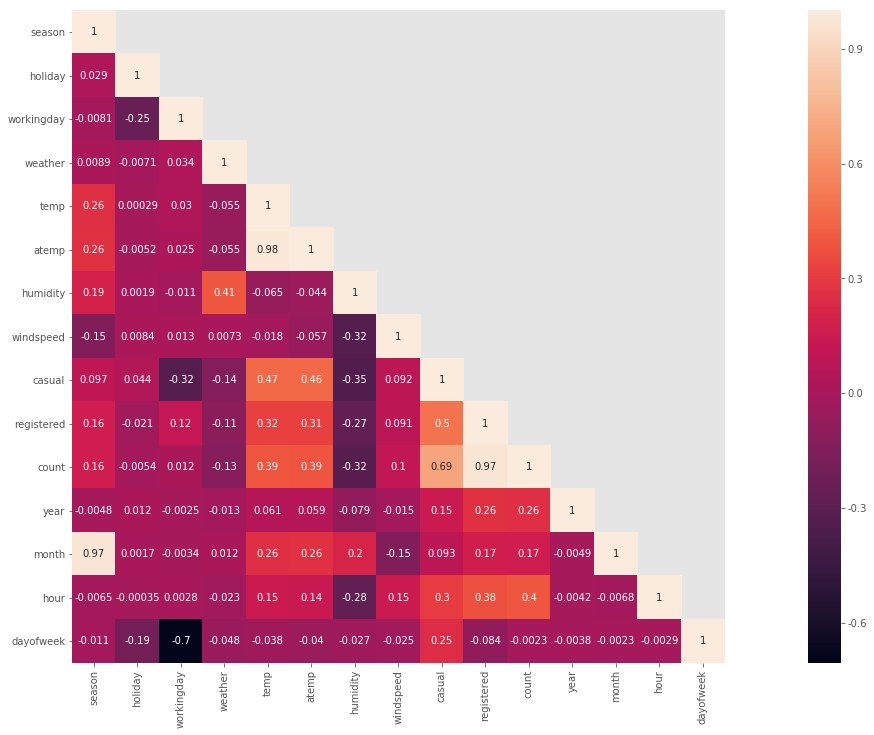

In [7]:
#corelation
corr= train[:].corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=corr,mask=mask,square=True,annot=True,cbar=True)

In [15]:
variable_category = ["season","holiday","workingday","weather","dayofweek","month","year","hour"]

for var in variable_category:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [9]:
features = ["season", "weather", "temp", "atemp", "humidity","year", "hour", "dayofweek", "holiday", "workingday"]
#feature = ["temp", "hour"]

In [10]:
X_train = train[features]
X_test = test[features]
label_name = "count"
y_train = train[label_name]
y_train_log = np.log1p(y_train)

In [11]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp=True):

    if convertExp:
        predicted_values = np.exp(predicted_values),
        actual_values = np.exp(actual_values)
        
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    mean_difference = difference.mean()
    
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

In [12]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [16]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
%time score = cross_val_score(lm, X_train, y_train_log, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
lm.fit(X_train, y_train_log)
prediction = lm.predict(X_train)

print("10-fold cross validation: {0:.5f}".format(score))
print ("RMSLE: ", rmsle(np.exp(y_train_log),np.exp(prediction), False))
print ("R squared: ", lm.score(X_train, y_train_log))

CPU times: user 349 ms, sys: 682 ms, total: 1.03 s
Wall time: 1.01 s
10-fold cross validation: 0.98131
RMSLE:  0.9803697923313507
R squared:  0.4852717792049213


In [17]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)
%time score = cross_val_score(rfModel, X_train, y_train_log, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
rfModel.fit(X_train, y_train_log)
preds = rfModel.predict(X_train)
score2 = rmsle(np.exp(y_train_log),np.exp(preds),False)

print("10-fold cross validation: {0:.5f}".format(score))
print ("RMSLE: ",score2)
print ("R squared: ",rfModel.score(X_train, y_train_log))

/srv/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


CPU times: user 31.3 s, sys: 937 ms, total: 32.3 s
Wall time: 33.7 s
10-fold cross validation: 0.28713
RMSLE:  0.10717442232896927
R squared:  0.9934516152772604


In [18]:
predsTest = rfModel.predict(X_test)

In [19]:
submission = pd.read_csv("sampleSubmission.csv")
submission

submission["count"] = np.exp(predsTest)

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.606997
1,2011-01-20 01:00:00,5.596211
2,2011-01-20 02:00:00,4.013045
3,2011-01-20 03:00:00,4.867953
4,2011-01-20 04:00:00,3.781588


In [20]:
#pd = pd.DataFrame(train)
#pd.to_csv("train_cleaned.csv", index=False )

Populating the interactive namespace from numpy and matplotlib


/srv/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Text(0.5, 1.0, 'linear model')

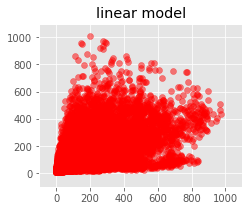

In [21]:
%pylab inline
pylab.figure(figsize=(8, 3))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(y_train, np.exp(prediction), alpha=0.5, color = 'red')
pylab.title('linear model')

Populating the interactive namespace from numpy and matplotlib


Text(0.5, 1.0, 'Random Forest')

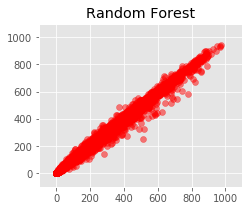

In [22]:
%pylab inline
pylab.figure(figsize=(8, 3))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(y_train, np.exp(preds), alpha=0.5, color = 'red')
pylab.title('Random Forest')

Text(0.5, 1.0, 'test (random forest)')

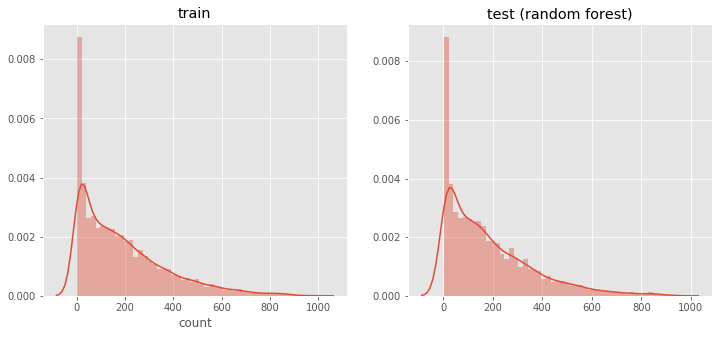

In [23]:
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50).set_title('train')
sns.distplot(np.exp(predsTest),ax=ax2,bins=50).set_title('test (random forest)')

Text(0.5, 1.0, 'test (linear regression)')

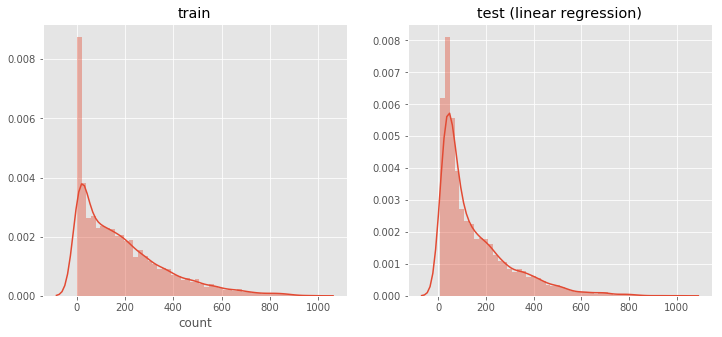

In [24]:
predsTest2 = lm.predict(X_test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50).set_title('train')
sns.distplot(np.exp(predsTest2),ax=ax2,bins=50).set_title('test (linear regression)')